Key Components
1. **StateGraph**: The core of our application, defining the flow of our Travel Planner.
2. **PlannerState**: A custom type representing the state of our planning process.
3. **Node Functions**: Individual steps in our planning process (input_city, input_interests, create_itinerary).
4. **LLM Integration**: Utilizing a language model to generate the final itinerary.



In [1]:
!pip install langchain langchain_core langchain_groq langchain_community langchain langgraph

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 39.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.4/152.4 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.6/129.6 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.2/44.2 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.5/216.5 kB 17.0 MB/s eta 0:00:00


In [2]:
import os
from typing import TypedDict, Annotated, List
from langgraph.graph import StateGraph, END
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables.graph import MermaidDrawMethod
from IPython.display import display, Image

Define Agent

In [3]:
class PlannerState(TypedDict):
  messages : Annotated[List[HumanMessage | AIMessage], "the messages in the conversation"]
  city: str
  interests: List[str]
  itinerary: str

In [ ]:
from langchain_groq import ChatGroq
llm = ChatGroq(
    temperature = 0,
    groq_api_key = #YOUR_GROQ_API",
    model_name = #"llama-3.3-70b-versatile"
)
result = llm.invoke("What is Multi AI Agent")
result.content

'A Multi-Agent System (MAS) is a system composed of multiple autonomous agents that interact with each other and their environment to achieve common or individual goals. In the context of Artificial Intelligence (AI), a Multi-AI Agent refers to a system that consists of multiple AI agents that work together to solve complex problems, make decisions, or perform tasks.\n\nCharacteristics of Multi-AI Agents:\n\n1. **Autonomy**: Each AI agent has its own autonomy to make decisions and take actions.\n2. **Interoperability**: AI agents can communicate and interact with each other.\n3. **Distributed Problem-Solving**: AI agents work together to solve complex problems that are difficult or impossible for a single agent to solve.\n4. **Decentralized Decision-Making**: Decision-making is distributed among the AI agents, and each agent contributes to the overall decision-making process.\n\nTypes of Multi-AI Agents:\n\n1. **Cooperative Agents**: Agents work together to achieve a common goal.\n2. *

In [5]:
from langchain.schema import SystemMessage, HumanMessage
from langchain.prompts import ChatPromptTemplate

In [6]:
itinerary_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a helpful travel assistant. Create a day trip itinerary for {city} based on the user's interests: {interests}. Provide a brief, bulleted itinerary."),
    ("human", "Create an itinerary for my day trip.")
])

Define Agent Function

In [7]:
def input_city(state: PlannerState) -> PlannerState:
         print("Please enter the city you want to visit for your day trip: ")
         user_message = input("Your Input: ")
         return {
              **state,
             "city": user_message,
             "messages": state['messages'] + [HumanMessage(content=user_message)]
         }

def input_interest(state: PlannerState) -> PlannerState:
        print(f"Please enter your interest for the trip to : {state['city']} (comma-separted): ")
        user_message = input("Your Input: ")
        return {
            **state,
            "interests": [interest.strip() for interest in user_message.split(",")],
            "messages": state['messages'] + [HumanMessage(content=user_message)]
          }
def create_itinerary(state: PlannerState) -> PlannerState:
        print(f"Creating an itinerary for {state['city']} based on interests : {', '.join(state['interests'])}")
        response = llm.invoke(itinerary_prompt.format_messages(city = state['city'], interests = ','.join(state['interests'])))
        print("\nFinal Itinerary: ")
        print(response.content)
        return {
            **state,
            "messages": state['messages'] + [AIMessage(content=response.content)],
            "itinerary" : response.content,
         }

In [30]:
def get_feedback(state):

    state["feedback"] = "not_collected"
    return state



Create and compile the graph


In [31]:
workflow = StateGraph(PlannerState)

workflow.add_node("input_city", input_city)
workflow.add_node("input_interest", input_interest)
workflow.add_node("create_itinerary", create_itinerary)
workflow.add_node("get_feedback", get_feedback)  # ← Now this will work

workflow.set_entry_point("input_city")

workflow.add_edge("input_city", "input_interest")
workflow.add_edge("input_interest", "create_itinerary")
workflow.add_edge("create_itinerary", "get_feedback")
workflow.add_edge("get_feedback", END)

app = workflow.compile()


Display the graph structure

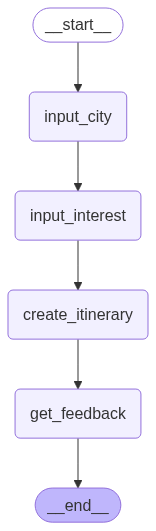

In [32]:
 display(
        Image(
           app.get_graph().draw_mermaid_png(
           draw_method = MermaidDrawMethod.API
                )
            )
 )

Define the function that runs the graph

In [33]:
 def travel_planner(user_request: str):
        print(f"Initial Request: {user_request}\n")
        state = {
            "messages": [HumanMessage(content=user_request)],
            "city": "",
            "interests": [],
            "itinerary": "",
          }
        for output in app.stream(state):
            pass

In [34]:
 user_request = "I want to plan a day trip"
 travel_planner(user_request)

Initial Request: I want to plan a day trip

Please enter the city you want to visit for your day trip: 
Your Input: roma
Please enter your interest for the trip to : roma (comma-separted): 
Your Input: history
Creating an itinerary for roma based on interests : history

Final Itinerary: 
For a history-focused day trip to Rome, consider the following itinerary:

* 9:00 AM: Start at the Colosseum, one of Rome's most iconic ancient landmarks and a testament to the city's rich history.
* 11:00 AM: Visit the Roman Forum, a sprawling archaeological site filled with ancient ruins and historical significance.
* 1:00 PM: Take a break for lunch at a traditional Italian restaurant near the forum.
* 2:30 PM: Explore the Pantheon, a magnificently preserved ancient temple with a rich history dating back to 126 AD.
* 4:30 PM: End your day with a visit to the Vatican Museums, home to some of the world's most famous historical and artistic treasures, including works from ancient civilizations.

This it

In [35]:
feedback = input("Please provide feedback on the itinerary (e.g., too fast-paced, missing attractions, etc.): ")


Please provide feedback on the itinerary (e.g., too fast-paced, missing attractions, etc.):  fast-paced


In [36]:
from textblob import TextBlob
sentiment = TextBlob(feedback).sentiment
print("Feedback sentiment:", sentiment)


Feedback sentiment: Sentiment(polarity=0.0, subjectivity=0.0)


In [37]:
prompt = f"""
Based on the user's feedback: "{feedback}", please enhance or modify the previous itinerary.
Make adjustments to better match user preferences and avoid past issues.
"""


In [38]:
with open("user_feedback_log.txt", "a") as f:
    f.write(feedback + "\n")


In [39]:
!pip install gradio

In [41]:
import gradio as gr
from typing import TypedDict, Annotated, List
from langgraph.graph import StateGraph, END
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_groq import ChatGroq

# Define the LLM
llm = ChatGroq(
    temperature=0,
    groq_api_key="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",
    model_name="llama-3.3-70b-versatile"
)

# Prompt template for itinerary generation
itinerary_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a helpful travel assistant. Create a day trip itinerary for {city} based on the user's interests: {interests}. Provide a brief, bulleted itinerary."),
    ("human", "Create an itinerary for my day trip."),
])

# Prompt template for feedback enhancement
feedback_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a helpful travel assistant. Improve the following itinerary based on this feedback: {feedback}."),
    ("human", "{itinerary}")
])

# State representation
class PlannerState(TypedDict):
    messages: Annotated[List[HumanMessage | AIMessage], "The messages in the conversation"]
    city: str
    interests: List[str]
    itinerary: str

# Step 1: Input City
def input_city(city: str, state: PlannerState) -> PlannerState:
    return {
        **state,
        "city": city,
        "messages": state['messages'] + [HumanMessage(content=city)],
    }

# Step 2: Input Interests
def input_interests(interests: str, state: PlannerState) -> PlannerState:
    return {
        **state,
        "interests": [interest.strip() for interest in interests.split(',')],
        "messages": state['messages'] + [HumanMessage(content=interests)]
    }

# Step 3: Create Initial Itinerary
def create_itinerary(state: PlannerState) -> str:
    response = llm.invoke(itinerary_prompt.format_messages(city=state['city'], interests=", ".join(state['interests'])))
    state["itinerary"] = response.content
    state["messages"] += [AIMessage(content=response.content)]
    return response.content

# Step 4: Update Itinerary with Feedback
def improve_itinerary(itinerary: str, feedback: str) -> str:
    improved = llm.invoke(feedback_prompt.format_messages(itinerary=itinerary, feedback=feedback))
    return improved.content

# Gradio handler function
def travel_planner(city: str, interests: str, feedback: str = ""):
    state = {
        "messages": [],
        "city": "",
        "interests": [],
        "itinerary": "",
    }

    # Create itinerary
    state = input_city(city, state)
    state = input_interests(interests, state)
    itinerary = create_itinerary(state)

    # Apply feedback if provided
    if feedback.strip():
        itinerary = improve_itinerary(itinerary, feedback)

    return itinerary

# Gradio Interface
interface = gr.Interface(
    fn=travel_planner,
    theme='Yntec/HaleyCH_Theme_Orange_Green',
    inputs=[
        gr.Textbox(label="Enter the city for your day trip"),
        gr.Textbox(label="Enter your interests (comma-separated)"),
        gr.Textbox(label="(Optional) Feedback to improve the itinerary"),
    ],
    outputs=gr.Textbox(label="Final Itinerary"),
    title="Travel Itinerary Planner with Feedback",
    description="Enter a city and your interests. Provide feedback to regenerate an improved itinerary."
)

interface.launch()


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://2956d6af6cc8e3907d.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
